# Getting started with PhenoScore
In this notebook, we will run some basic analyses using PhenoScore to demonstrate how it works.
First, lets get started and import the installed package (for instructions, please see the README.md)

In [11]:
from phenoscore.phenoscorer import PhenoScorer
import os

Then, decided on what mode you want to run PhenoScore in: HPO-only, facial-features only, or using both. 
For now, we will do both and intialize PhenoScore with the standard options. PhenoScore will autodetect any GPUs that are available and if there are none, revert to CPU mode. If there are no GPUs detected, while there should be, please double check your installation and confirm cuDNN is installed in this environment as well.

In [12]:
mode = 'both'
N_LIME = 1 #this is purely for speed during testing purposes: for same results as in paper, set N_LIME=5

phenoscorer = PhenoScorer(gene_name='SATB1', 
                          mode=mode,
                          method_hpo_similarity='Resnik',
                          method_summ_hpo_similarities='BMA',
                         face_module='QMagFace')

Using GPUs:1
Pretrained weights not yet available, downloading them now.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Downloaded pretrained weights.
=> loading pth from C:\Users\Z184215\Documents\H_schijf_Lex\Projecten\FaceReader\Scripts\PhenoScore\PhenoScore\phenoscore\facial_feature_extraction\QMagFace\_models\magface_models\magface_epoch_00025.pth ...


Now that PhenoScore is ready, let's load data. In this case, let's take a look at the SATB1 subgroup analyses: the data is included in the package.

In [13]:
X, y, img_paths, df_data = phenoscorer.load_data_from_excel(os.path.join('../', 'phenoscore', 'sample_data','satb1_data.xlsx'))
print('Data loaded!')

Data loaded!


In [4]:
print(X)

[[-1.0466831 -0.024507554 1.5157256 ... -0.849308 0.65444916
  list(['HP:0002015', 'HP:0002307', 'HP:0000324', 'HP:0006482', 'HP:0001263', 'HP:0000356', 'HP:0000364', 'HP:0002650', 'HP:0000776', 'HP:0000646', 'HP:0001260', 'HP:0000902', 'HP:0031936', 'HP:0004880', 'HP:0001256', 'HP:0030021', 'HP:0000750', 'HP:0000168', 'HP:0000271', 'HP:0000708', 'HP:0000413', 'HP:0001270'])]
 [0.45322195 1.2440773 1.1922555 ... 0.038673602 -1.0815593
  list(['HP:0012015', 'HP:0000750', 'HP:0002643', 'HP:0011342', 'HP:0040083', 'HP:0002720', 'HP:0003496', 'HP:0000271', 'HP:0001250', 'HP:0001256', 'HP:0011054', 'HP:0002275', 'HP:0002280', 'HP:0004315', 'HP:0025502', 'HP:0001270'])]
 [0.11083773 -0.5215106 0.2013677 ... -0.045515653 -2.3599765
  list(['HP:0000750', 'HP:0005484', 'HP:0002307', 'HP:0011410', 'HP:0008936', 'HP:0003487', 'HP:0025116', 'HP:0000483', 'HP:0011344', 'HP:0001270'])]
 ...
 [1.0497137 1.0705472 0.9422452 ... -1.1541563 -1.3748822
  list(['HP:0000680', 'HP:0001252', 'HP:0002353', 'H

Now that the data is loaded, we can run the permutation test, to see if we can distinguish the two groups.

In [5]:
phenoscorer.permutation_test(X, y, bootstraps=1000)
print("Brier:" + str(phenoscorer.permutation_test_brier))
print("AUC:" + str(phenoscorer.permutation_test_auc))
print("P value:" + str(phenoscorer.permutation_test_p_value))

100%|██████████| 1001/1001 [03:03<00:00,  5.46it/s]


Brier:0.1712468984432235
AUC:0.859375
P value:0.013986013986013991


The result is significant! So PhenoScore is able to detect a phenotypic difference between the two groups. Of course, we would like to know what the clinical difference is. So let's investigate this, using LIME. 

Starting cross validation procedure to compare using facial/HPO data only with PhenoScore.
Finished cross validation and evaluation of model scores. Now starting LIME for the top 1 predictions to generate heatmaps and visualise phenotypic differences.


100%|██████████| 1/1 [06:41<00:00, 401.20s/it]


Figure saved as lime_figure.pdf


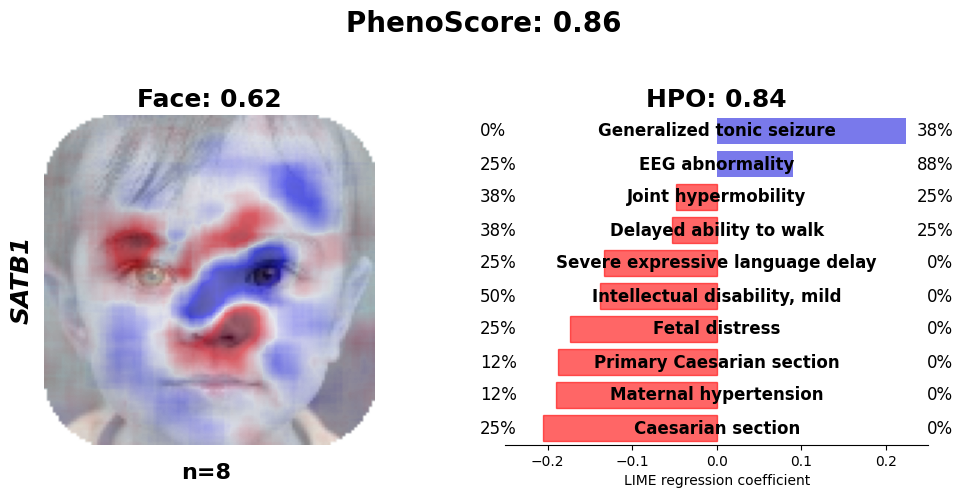

LIME images generated!


In [6]:
phenoscorer.get_lime(X, y, img_paths, n_lime=N_LIME)
phenoscorer.gen_lime_and_results_figure(bg_image=os.path.join('../', 'phenoscore', 'sample_data','background_image.jpg'),
                                        df_data=df_data, filename='lime_figure.pdf')
print("LIME images generated!")

Finally, we can generate a VUS prediction for a SATB1 individual (as if it where an individual with a VUS, of course in this case, purely for demonstrational purposes). Because of the demonstrational purpose and speed, we choose ``lime_iter=10``(normally we would do ``lime_iter=100`` to obtain a higher resolution heatmap).

Predictive score between 0 (control) and 1 (syndrome): [0.05812746]
Figure saved as individual_lime_explanations.pdf


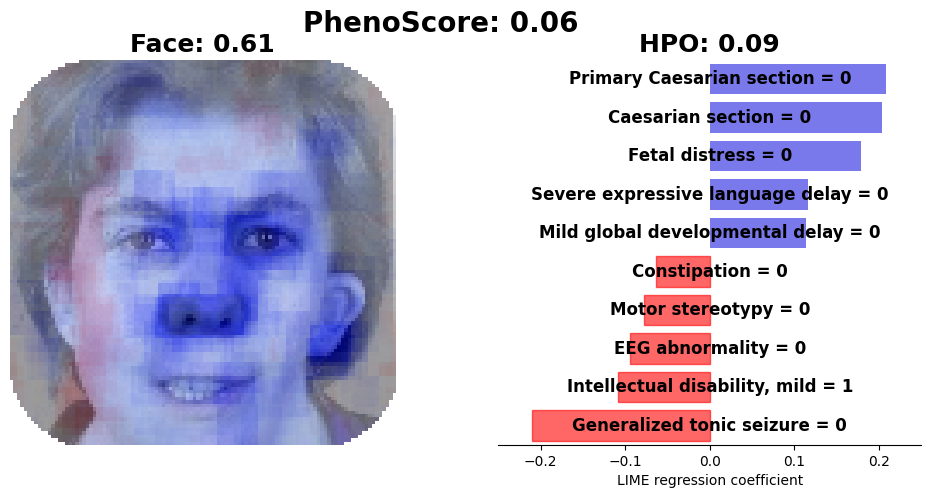

In [7]:
phenoscorer.predict_new_sample(X, y, img_paths[0], X[0,-1], lime_iter=10)
print("Predictive score between 0 (control) and 1 (syndrome): " + str(phenoscorer.vus_results[0]))
phenoscorer.gen_vus_figure(filename='individual_lime_explanations.pdf')

We can do the same procedures for HPO-only mode as well, simply by just changing that parameter.

Using GPUs:1
Data loaded!


100%|██████████| 1001/1001 [02:02<00:00,  8.20it/s]


Brier:0.19844019193794765
AUC:0.828125
P value:0.02197802197802199
Starting cross validation procedure to compare using facial/HPO data only with PhenoScore.
Finished cross validation and evaluation of model scores. Now starting LIME for the top 1 predictions to generate heatmaps and visualise phenotypic differences.


100%|██████████| 1/1 [00:28<00:00, 28.21s/it]


Figure saved as lime_figure.pdf


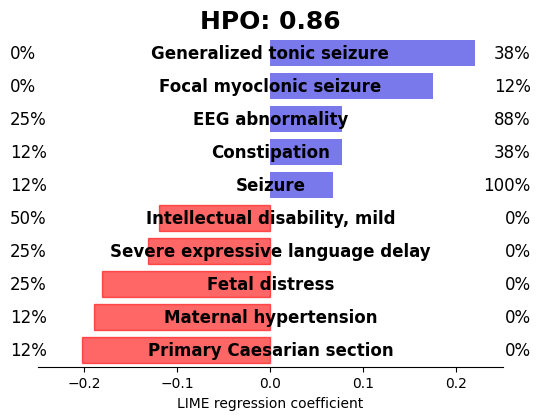

LIME images generated!


In [8]:
mode = 'hpo'
phenoscorer = PhenoScorer(gene_name='SATB1', 
                          mode=mode,
                          method_hpo_similarity='Resnik',
                          method_summ_hpo_similarities='BMA')
X, y, img_paths, df_data = phenoscorer.load_data_from_excel(os.path.join('../', 'phenoscore', 'sample_data','satb1_data.xlsx'))
print('Data loaded!')
phenoscorer.permutation_test(X, y, bootstraps=1000)
print("Brier:" + str(phenoscorer.permutation_test_brier))
print("AUC:" + str(phenoscorer.permutation_test_auc))
print("P value:" + str(phenoscorer.permutation_test_p_value))
phenoscorer.get_lime(X, y, img_paths, n_lime=N_LIME)
phenoscorer.gen_lime_and_results_figure(bg_image=os.path.join('../', 'phenoscore', 'sample_data','background_image.jpg'),
                                        df_data=df_data, filename='lime_figure.pdf')
print("LIME images generated!")

And similar when only using facial images (or when these are the only ones available):

Using GPUs:1
Pretrained weights already exist, skipping download.
=> loading pth from C:\Users\Z184215\Documents\H_schijf_Lex\Projecten\FaceReader\Scripts\PhenoScore\PhenoScore\phenoscore\facial_feature_extraction\QMagFace\_models\magface_models\magface_epoch_00025.pth ...
Data loaded!


100%|██████████| 1001/1001 [02:31<00:00,  6.60it/s]


Brier:0.25987248980524846
AUC:0.515625
P value:0.7062937062937037
Starting cross validation procedure to compare using facial/HPO data only with PhenoScore.
Finished cross validation and evaluation of model scores. Now starting LIME for the top 1 predictions to generate heatmaps and visualise phenotypic differences.


100%|██████████| 1/1 [05:28<00:00, 328.24s/it]


Figure saved as lime_figure.pdf


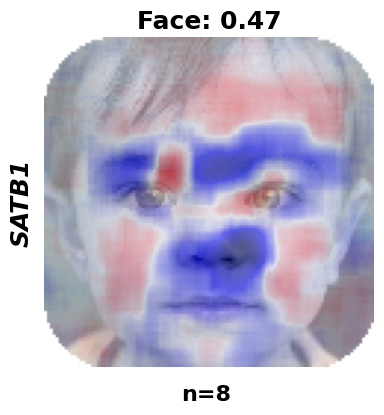

LIME images generated!


In [9]:
mode = 'face'
phenoscorer = PhenoScorer(gene_name='SATB1', 
                          mode=mode,
                          method_hpo_similarity='Resnik',
                          method_summ_hpo_similarities='BMA')
X, y, img_paths, df_data = phenoscorer.load_data_from_excel(os.path.join('../', 'phenoscore', 'sample_data','satb1_data.xlsx'))
print('Data loaded!')
phenoscorer.permutation_test(X, y, bootstraps=1000)
print("Brier:" + str(phenoscorer.permutation_test_brier))
print("AUC:" + str(phenoscorer.permutation_test_auc))
print("P value:" + str(phenoscorer.permutation_test_p_value))
phenoscorer.get_lime(X, y, img_paths, n_lime=N_LIME)
phenoscorer.gen_lime_and_results_figure(bg_image=os.path.join('../', 'phenoscore', 'sample_data','background_image.jpg'),
                                        df_data=df_data, filename='lime_figure.pdf')
print("LIME images generated!")